In [1]:
import discretize
from SimPEG import maps
import numpy as np
import matplotlib.pyplot as plt

import BTInvert
import uxo_utils

import polarizability_model as pm

from matplotlib import rcParams
rcParams["font.size"] = 14

In [2]:
sensorinfo = uxo_utils.load_sensor_info("UltraTEM")
ordnance = uxo_utils.load_ordnance_dict()

In [3]:
sensorinfo.transmitters[1].shape

array([[ 0.3  ,  0.475, -0.06 ],
       [ 0.3  , -0.475, -0.06 ],
       [-0.7  , -0.475, -0.06 ],
       [-0.7  ,  0.475, -0.06 ]])

In [4]:
times = ordnance["ISO Small"]["times"]
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [5]:
n_lines = 1
line_length = 3
line_spacing = 0.5*line_length/n_lines
survey_dict = uxo_utils.create_survey(
    sensorinfo,
    times, 
    line_length=line_length,
    along_line_spacing=0.2,
    line_spacing=line_spacing,
    n_lines=n_lines,
    starting_point=np.r_[-1, 0]*line_length/2,
    z=0.28,
    pitch=0,
    roll=0,
    yaw=0,
)

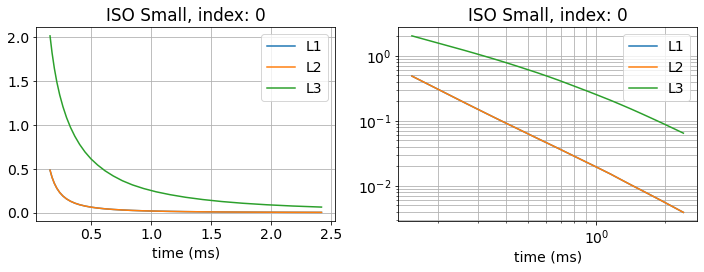

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
key = "ISO Small"
i = 0
for l in ["L1", "L2", "L3"]:
    L = ordnance[key][l][i]
    ax[0].plot(times, L, label=l)
    ax[1].loglog(times, L, label=l)

for a in ax:
    a.set_title(f"{key}, index: {i}")
    a.grid(which="both")
    a.legend()
    a.set_xlabel("time (ms)")
    # a.set_ylim([1e-3, 20])
        
plt.tight_layout()

In [7]:
fwd_params = uxo_utils.create_forward_modelling_params(
    sensorinfo, times, 
    survey_dict["mnum"], survey_dict["pos"], 
    survey_dict["pitch"], survey_dict["roll"], survey_dict["yaw"]
)

In [8]:
key = "ISO Small"
ind = 0
ord_loc = np.r_[0, 0, -0.1]
ord_ypr = np.r_[0, 0, 0]

L3, L2, L1 = (ordnance[key][l][ind] for l in ["L1", "L2", "L3"])

data_uxo = uxo_utils.simulate_object(
    L1, L2, L3, fwd_params, times, ord_loc, ord_ypr
)



In [9]:
mod = BTInvert.Model(xyz=ord_loc, gba=ord_ypr, l3=L3, l2=L2, l1=L1, times=times)

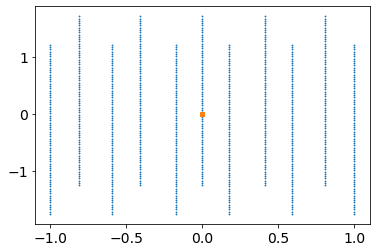

In [10]:
plt.plot(survey_dict["pos"][:, 0], survey_dict["pos"][:, 1], '.', alpha=0.8, ms=1)
plt.plot(ord_loc[0], ord_loc[1], 's', ms=4)

In [11]:
sensor_table = sensorinfo.measNum2TxRxRxcCube()
# sensor_table = sensor_table[mnum, :]

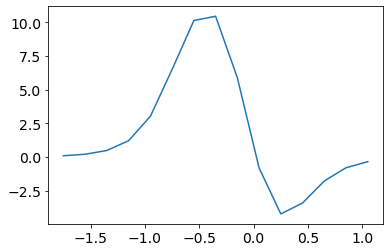

In [12]:
mnum_plot = 11
fig, ax = plt.subplots(1, 1)
ax.plot(
    survey_dict["pos"][survey_dict["mnum"] == mnum_plot, 1], 
    data_uxo[mnum_plot, :, 0]
)

In [13]:
# loop over transmitters
src_list = []
nrx = sensor_table[:, 3].max() + 1
ncomponents = sensor_table[:, 2].max() + 1
ndata = nrx*ncomponents

for i, txi in enumerate(survey_dict["txnum"]): 
    tx = sensorinfo.transmitters[txi]
    tx_corners = tx.shape + survey_dict["xyz"][i, :]
    tx_corners = np.vstack([tx_corners, tx_corners[:1, :]])  # close the loop

    receiver_inds = slice(i*ndata,i*ndata + nrx)

    receivers = pm.MagneticFluxDensityReceiver(
        survey_dict["pos"][receiver_inds, :], 
        components=["z", "y", "x"]
    )
    src = pm.MagneticControlledSource(receiver_list=[receivers], location=tx_corners, current=1)
    src_list.append(src)

In [14]:
survey = pm.Survey(src_list)
survey.nD

2475

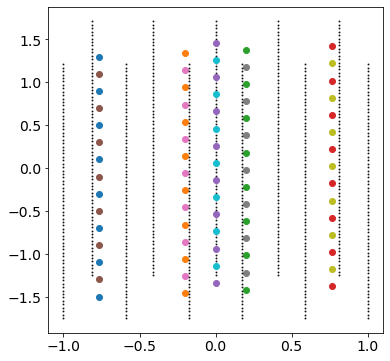

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# mesh.plot_grid(ax=ax, linewidth=1)

for src in survey.source_list: 
    rx_locs = src.receiver_list[0].locations
    ax.plot(
        (src.location[:, 0].min() + src.location[:, 0].max())/2.,
        (src.location[:, 1].min() + src.location[:, 1].max())/2.,
        "o"
    )
    ax.plot(rx_locs[:, 0], rx_locs[:, 1], '.k', alpha=0.8, ms=2)
    # ax.plot(ord_loc[0], ord_loc[1], 's',color="C1", ms=4)

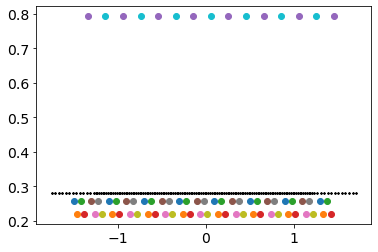

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# mesh.plot_grid(ax=ax, linewidth=1)

for src in survey.source_list: 
    rx_locs = src.receiver_list[0].locations
    ax.plot(
        (src.location[:, 1].min() + src.location[:, 1].max())/2.,
        (src.location[:, 2].min() + src.location[:, 2].max())/2.,
        "o"
    )
    ax.plot(rx_locs[:, 1], rx_locs[:, 2], '.k', alpha=0.8, ms=2)
    # ax.plot(ord_loc[0], ord_loc[1], 's',color="C1", ms=4)

In [17]:
core_domain = 2 # meters
nc = 32
dx = core_domain/nc
npad = 6
pf = 1.3
hx = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
hy = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
mesh = discretize.TensorMesh([hx, hy], origin="CC")
mesh.n_cells

1936

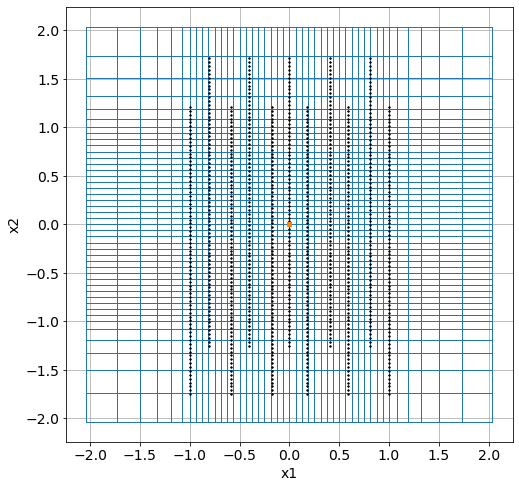

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

mesh.plot_grid(ax=ax, linewidth=1)
ax.plot(survey_dict["pos"][:, 0], survey_dict["pos"][:, 1], '.k', alpha=0.8, ms=2)
ax.plot(ord_loc[0], ord_loc[1], 's',color="C1", ms=4)

In [19]:
locations = np.hstack([mesh.gridCC, np.zeros((mesh.nC, 1))])

In [20]:
sim = pm.SimulationPolarizabilityModel(locations, survey)

In [21]:
ntx = int(survey_dict["txnum"].max()) + 1

def reorder_mnum(sensor_table):
    return np.hstack([
        np.hstack([
            np.where(
                (sensor_table[:, 3] == rxi) & 
                (sensor_table[:, 0] == txi)
            )[0] 
                for rxi in range(nrx)
        ]) for txi in range(ntx)
    ])

In [22]:
mnum_reordered = reorder_mnum(sensor_table)
# sensor_table[mnum_reordered, :]

In [23]:
sensor_table_expanded = sensor_table[survey_dict["mnum"], :]
expanded_reorder = reorder_mnum(sensor_table_expanded)

In [24]:
pos_reordered = survey_dict["pos"][expanded_reorder, :]

In [25]:
# reorder so it is by reciever cube and then location
tind = 0
d_invert = data_uxo[:, :, tind]
d_invert = d_invert[mnum_reordered, :].flatten(order="F")

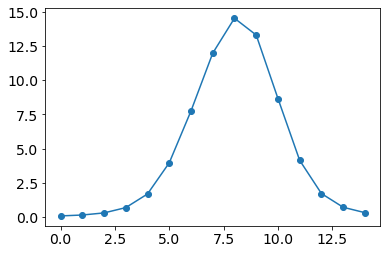

In [26]:
plt.plot(data_uxo[0, :, 0], "-o")

In [27]:
mtest = np.zeros_like(locations)

x_target = np.r_[-0.25, 0.25]
y_target = np.r_[-0.25, 0.25]
m_target = np.r_[1, 1, 10]

bounding_box = (
    (locations[:, 0] > x_target.min()) &
    (locations[:, 0] < x_target.max()) &
    (locations[:, 1] > y_target.min()) &
    (locations[:, 1] < y_target.max()) 
)
for i, m in enumerate(m_target): 
    mtest[bounding_box, i] = m

mtest = mtest.flatten() #discretize.utils.mkvc(mtrue)

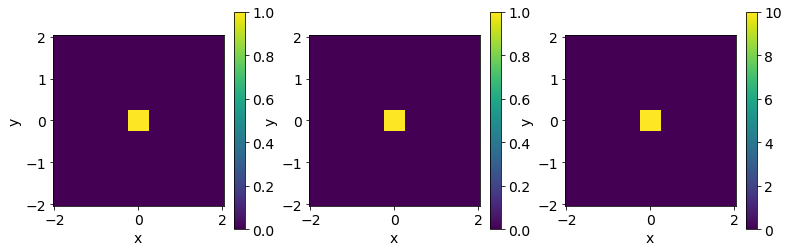

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mtest[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

In [29]:
dpred_test = sim.dpred(mtest)

In [30]:
np.abs(dpred_test).max()

1119.3550063431067

In [31]:
noise_floor = 0.01*np.max(np.abs(dpred_test))
inversion_test = pm.Inversion(sim, dpred_test, noise_floor, beta=None)

In [32]:
mrec_test = inversion_test.solve(beta_fact=100)

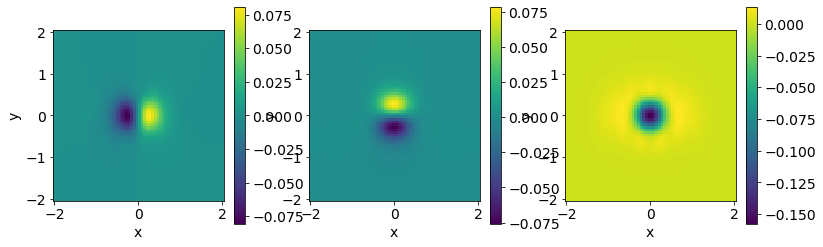

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec_test[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

In [34]:
sim_pos = pm.SimulationPolarizabilityModel(locations, survey, mapping=maps.IdentityMap(nP=3*mesh.nC))

In [35]:
noise_floor = 0.01 * np.max(np.abs(dpred_test))
inversion_test = pm.Inversion(sim_pos, dpred_test, noise_floor, beta=None)

In [36]:
from SimPEG import data_misfit, regularization, optimization, inverse_problem, inversion, directives, Data

In [37]:
dmis_test = data_misfit.L2DataMisfit(data=Data(survey, dobs=dpred_test, noise_floor=noise_floor), simulation=sim_pos)
# wires = maps.Wires(("x", mesh.nC), ("y", mesh.nC), ("z", mesh.nC))
nmodel = mesh.nC*3
map_x = maps.Projection(nP=nmodel, index=slice(0,nmodel,3))
map_y = maps.Projection(nP=nmodel, index=slice(1,nmodel,3))
map_z = maps.Projection(nP=nmodel, index=slice(2,nmodel,3))
reg_test = (
    regularization.SimpleSmall(mesh, mapping=map_x, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_y, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_z, mref=np.zeros(len(locations)*3))  
)

In [38]:
opt_test = optimization.ProjectedGNCG(maxIterCG=60, stepOffBoundsFact=1e-8, lower=0, maxIter=20) 
invprob_test = inverse_problem.BaseInvProblem(dmis_test, reg_test, opt_test) 

In [39]:
directive_list = [
    directives.BetaEstimate_ByEig(beta0_ratio=1), 
    directives.BetaSchedule(coolingFactor=2.0, coolingRate=1),
    directives.TargetMisfit()
]

In [40]:
inv_test = inversion.BaseInversion(invprob_test, directive_list)

In [42]:
mrec_test = inv_test.run(np.zeros(mesh.nC * 3)+1e-8)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.49e+01  6.58e+04  2.90e-13  6.58e+04    1.94e+03      0              


/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   1  1.75e+01  2.07e+04  4.55e+02  2.87e+04    5.23e+02      0              
   2  8.73e+00  1.05e+04  8.69e+02  1.81e+04    3.62e+02      0   Skip BFGS  
   3  4.36e+00  4.47e+03  1.35e+03  1.04e+04    2.24e+02      0   Skip BFGS  
   4  2.18e+00  1.74e+03  1.78e+03  5.62e+03    1.29e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 6.5770e+03
0 : |xc-x_last| = 6.9413e+00 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 1.2877e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.2877e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      20    <= iter          =      5
------------------------- DONE! -------------------------


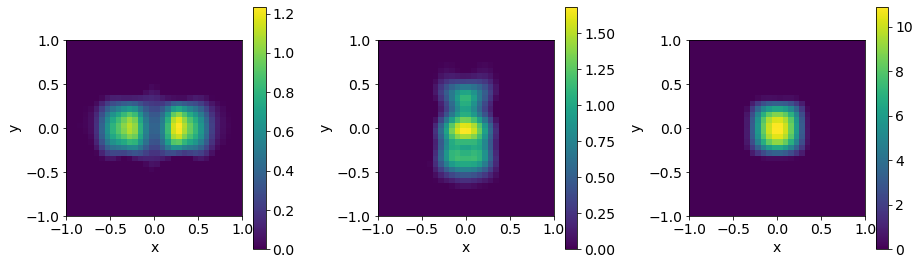

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec_test[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)
    a.set_xlim([-1, 1])
    a.set_ylim([-1, 1])
plt.tight_layout()

## Now with UXO simulation 

In [44]:
# reorder so it is by reciever cube and then location
# NOTE: for multiple lines with different yaw, we will need to rotate data
tind = 0
data_uxo_rotated = data_uxo.copy()

d_invert = data_uxo[:, :, tind]
d_invert = d_invert[mnum_reordered, :].flatten(order="F")

In [45]:
d_invert.max()

450.25759687785546

In [46]:
sim = pm.SimulationPolarizabilityModel(locations, survey, mapping=maps.IdentityMap(nP=3*mesh.nC))

In [47]:
noise = 0.05*np.max(np.abs(d_invert)) + 0.05*np.abs(d_invert)
inversion_uxo = pm.Inversion(sim, d_invert, noise_floor, beta=None)

In [57]:
mrec0 = inversion_uxo.solve(beta_fact=1000)

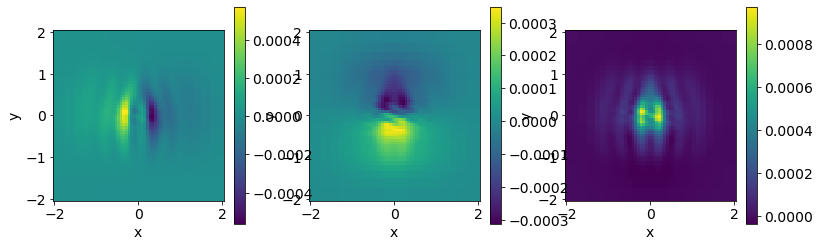

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec0[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

## Now with simpeg

In [59]:
dmis = data_misfit.L2DataMisfit(
    data=Data(
        survey, dobs=d_invert, 
        noise_floor=0.05*np.abs(d_invert).max(), 
        relative_error=0.05
    ), 
    simulation=sim
)

nmodel = mesh.nC*3
map_x = maps.Projection(nP=nmodel, index=slice(0,nmodel,3))
map_y = maps.Projection(nP=nmodel, index=slice(1,nmodel,3))
map_z = maps.Projection(nP=nmodel, index=slice(2,nmodel,3))
reg = (
    regularization.SimpleSmall(mesh, mapping=map_x, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_y, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_z, mref=np.zeros(len(locations)*3))  
)

In [60]:
opt = optimization.ProjectedGNCG(maxIterCG=60, stepOffBoundsFact=1e-8, lower=0, maxIter=20) 
invprob = inverse_problem.BaseInvProblem(dmis, reg, opt) 

In [61]:
directive_list = [
    directives.BetaEstimate_ByEig(beta0_ratio=1), 
    directives.BetaSchedule(coolingFactor=2.0, coolingRate=1),
    directives.TargetMisfit()
]

In [62]:
inv = inversion.BaseInversion(invprob, directive_list)

In [63]:
mrec = inv.run(np.zeros(mesh.nC * 3)+1e-8)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.21e+00  3.32e+03  2.90e-13  3.32e+03    3.25e+00      0              
   1  4.10e+00  3.32e+03  1.35e-01  3.32e+03    8.64e-01      0              
   2  2.05e+00  3.32e+03  2.22e-01  3.32e+03    1.20e+00      0   Skip BFGS  
   3  1.03e+00  3.32e+03  6.04e-01  3.32e+03    1.11e+00      0              
   4  5.13e-01  3.32e+03  1.86e+00  3.32e+03    7.55e-01      0   Skip BFGS  
   5  2.56e-01  3.32e+03  2.76e+00  3.32e+03    9.73e-01      3   Skip BFGS  
   6  1.28e-01  3.31e+03  5.11e+00  3.32e+03    1.09e+00      2   Skip BFGS  
----------------------------------

In [64]:
dmis(mrec)

3314.7157507573834

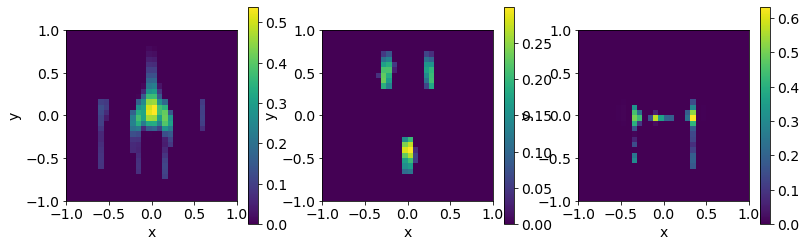

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec[i::3], ax=a)[0], ax=a)
    a.set_xlim([-1, 1])
    a.set_ylim([-1, 1])
    a.set_aspect(1)
    